## Sample 7.3 Hierarchical Model: Coma cluster (again)

First, draw $\tau$ from $p(\tau|y)$;

Then, draw $\mu$ from $p(\mu|\tau,y)$.


In [23]:
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
import scipy.special as special

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 


def loadData(filename):
    '''
    Read fits data
    
    '''
    tchfits = fits.open(filename)
    tabl = tchfits[1].data
    return tabl

#prior of tau, non-informative prior used here
def prior_tau(tau):
    return 1#/tau**2

#posterior of tao given y, in logarithmic form
def lnpost_tau_y(tau, y_bar, sigma2, J):
    lnp = np.zeros(np.shape(tau))
    for i in range(len(tau)):
        inv_s2 = 1/(sigma2+tau[i]**2)
        mu_hat = np.sum(y_bar*inv_s2)/np.sum(inv_s2)
        V_mu = 1/np.sum(inv_s2)
        lnp[i] = prior_tau(tau[i])+0.5*np.log(V_mu)
        #print inv_s2,mu_hat,V_mu,lnp[i]
        if J>1:
            for j in range(J):
                lnp[i] += 0.5*np.log(inv_s2[j])-\
                    0.5*(y_bar[j]-mu_hat)**2*inv_s2[j]
        else:
            lnp[i] += 0.5*np.log(inv_s2)-\
                0.5*(y_bar-mu_hat)**2*inv_s2
        #print 0.5*np.log(inv_s2)-\
         #       0.5*(y_bar-mu_hat)**2*inv_s2
    return lnp

def draw_tau(y_bar, sigma2, J, N=10000, \
             xmin=0,xmax=40,ymin=0,ymax=0.006, dy=0):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=xmin,high=xmax,size=N*20)
        y0 = np.log(np.random.uniform(low=ymin,\
                    high=ymax,size=N*20))
        y1 = lnpost_tau_y(x0,y_bar,sigma2,J)-dy
        
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        #print k,m
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])

#draw mu from its conditional posterior given tau and y
def draw_condpost_mu(y_bar, sigma2, tau, N):
    mu = np.zeros(np.shape(tau))
    for i in range(N):
        inv_s2 = 1/(sigma2+tau[i]**2)
        mu_hat = np.sum(y_bar*inv_s2)/np.sum(inv_s2)
        V_mu = 1/np.sum(inv_s2)
        mu[i] = np.random.normal(mu_hat, np.sqrt(V_mu))
    return mu




Load data of Coma cluster

1316.8409611736695


Text(0.5, 0, 'redshift (km/s)')

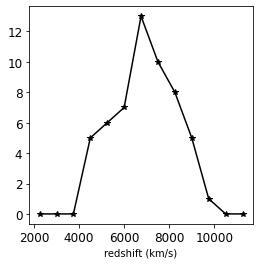

In [24]:
## the mean redshift of Coma cluster
filename = 'ComaCluster.fits'
coma = loadData(filename)
cz = coma.czA[(coma.czA<20000) & (coma.czA>0)]
ecz = coma.e_czA[(coma.czA<20000) & (coma.czA>0)]
sig_cz = np.var(cz)
print( np.sqrt(sig_cz))
zgrid =np.arange(2000.,12000.,750.)
h, xedge = np.histogram(cz, bins=zgrid)
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(zgrid[0:-1]+250.,h,'k*-')
ax.set_xlabel('redshift (km/s)')
# fig.show()

sampling $\tau$ and $\mu$

In [25]:
N = 50000
J = len(cz)
y_bar = [float(cz[j]) for j in range(J)]
sigma2 = [float(ecz[j])**2 for j in range(J)]


tau_d = draw_tau(y_bar, sigma2, J, N, \
                 xmin=600.,xmax=3000.,\
                 ymin=0,ymax=0.8,dy=-416)
mu_d = draw_condpost_mu(y_bar, sigma2, tau_d, N)




Draw posterior distributions

Text(0, 0.5, '$\\tau$')

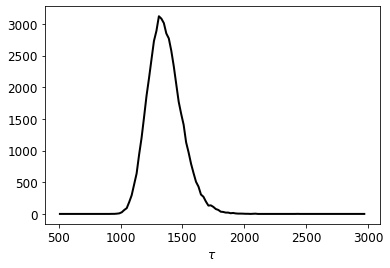

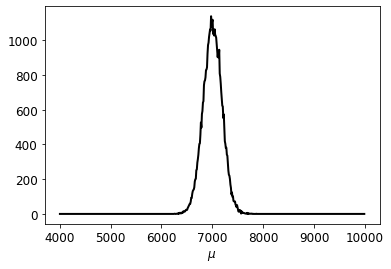

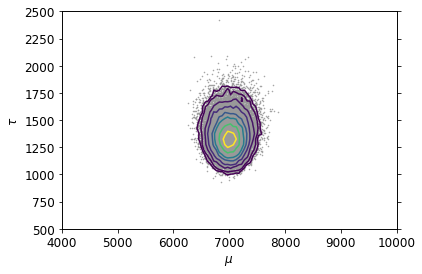

In [6]:
#draw posterior density of tau p(tau|y)
fig = plt.figure()
ax = fig.add_subplot(111)
taugrid = np.arange(500,3000,20)
taucenter = (taugrid[:-1]+taugrid[1:])/2.0
htau,xedge = np.histogram(tau_d, bins=taugrid)
ax.plot(taucenter,htau,'k',linewidth=2)
ax.set_xlabel(r'$\tau$',fontsize=12)
# fig.show()

#draw posterior density of mu p(mu|tau,y)
fig = plt.figure()
ax = fig.add_subplot(111)
mugrid = np.arange(4000.,10000,10.)
mucenter = (mugrid[:-1]+mugrid[1:])/2.0
hmu,xedge = np.histogram(mu_d, bins=mugrid)
ax.plot(mucenter,hmu,'k',linewidth=2)
ax.set_xlabel(r'$\mu$',fontsize=12)
# fig.show()

#draw joint posterior density of mu p(mu,tau|y)
taugrid2 = np.arange(500,3000,50)
taucenter2 = (taugrid2[:-1]+taugrid2[1:])/2.0
mugrid2 = np.arange(4000.,10000.,50)
mucenter2 = (mugrid2[:-1]+mugrid2[1:])/2.0
mumesh,taumesh = np.meshgrid(mucenter2, taucenter2)
mp,xedge,ydge = np.histogram2d(mu_d.reshape((N,)), \
        tau_d.reshape((N,)), bins=[mugrid2, taugrid2])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mu_d,tau_d,'.',\
        markeredgecolor=[0.6,0.6,0.6],\
        markerfacecolor=[0.6,0.6,0.6],\
       markersize=1)
ax1 = ax.twinx()
ax1.contour(mumesh, taumesh, mp.T, \
    levels=np.array([10,20,50,100,200,300,500,700]))
ax1.set_xlim([4000,10000])
ax1.set_ylim([500,2500])
ax1.set_yticklabels([])
ax.set_xlim([4000,10000])
ax.set_ylim([500,2500])

ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\tau$',fontsize=12)
# fig.show()

Text(0, 0.5, '$sd(\\theta_j|\\mu,\\tau,\\bar{y_{\\cdot j}}$)')

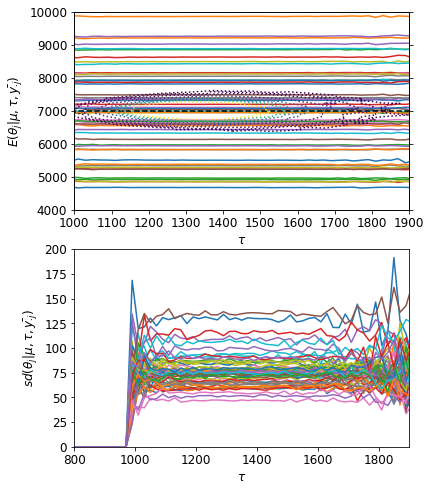

In [18]:
#check individual samples
#sample theta_j from p(theta_j|mu,tau,y)
def draw_post_theta_j(mu,tau,y_bar_j,sigma2_j):
    V_j = 1/(1/sigma2_j+1/tau**2)
    theta_j_hat = (y_bar_j/sigma2_j+mu/tau**2)*V_j
    theta_j = np.random.normal(theta_j_hat, np.sqrt(V_j))
    return theta_j

theta = np.zeros((J,N))
for i in range(J):
    theta[i,:] = draw_post_theta_j(\
        mu_d,tau_d,float(y_bar[i]),sigma2[i]).reshape((N))

E_theta = np.zeros((J,len(taucenter)))
D_theta = np.zeros((J,len(taucenter)))
for i in range(J):
    for t in range(len(taucenter)):
        ind = ((tau_d>taugrid[t]) & \
               (tau_d<=taugrid[t+1])).reshape((N,))
        if np.sum(ind)>5:
            #print np.shape(theta[i,ind.reshape((N,))])
            E_theta[i,t] = np.mean(theta[i,ind])
            D_theta[i,t] = np.sum((theta[i,ind]-\
                    E_theta[i,t])**2)/(np.sum(ind)-1)
        
taumesh,mumesh = np.meshgrid(taucenter2, mucenter2)
mp,xedge,ydge = np.histogram2d(tau_d.reshape((N,)), \
        mu_d.reshape((N,)), bins=[taugrid2, mugrid2])
fig = plt.figure(figsize=[6,8])
#mean_theta as a function of tau
ax = fig.add_subplot(211)
for i in range(J):
    ax.plot(taucenter, E_theta[i,:], '-')
ax.plot([0,10000],[np.mean(mu_d),np.mean(mu_d)],'k--')
ax1 = ax.twinx()
ax1.contour(taumesh,mumesh, mp.T, \
    levels=np.array([5,10,20,50,100,150,200,300]),\
           linestyles='dotted')
ax1.set_xlim([1000,1900])
ax1.set_ylim([4000,10000])
ax1.set_yticklabels([])
ax.set_xlim([1000,1900])
ax.set_ylim([4000,10000])
ax.set_xlabel(r'$\tau$',fontsize=12)
ax.set_ylabel(r'$E(\theta_j|\mu,\tau,\bar{y_{\cdot j}}$)',\
              fontsize=12)

ax = fig.add_subplot(212)
for i in range(J):
    ax.plot(taucenter, np.sqrt(D_theta[i,:]), '-')
ax.set_xlim([800,1900])
ax.set_ylim([0,200])
ax.set_xlabel(r'$\tau$',fontsize=12)
ax.set_ylabel(r'$sd(\theta_j|\mu,\tau,\bar{y_{\cdot j}}$)',\
              fontsize=12)
# fig.show()

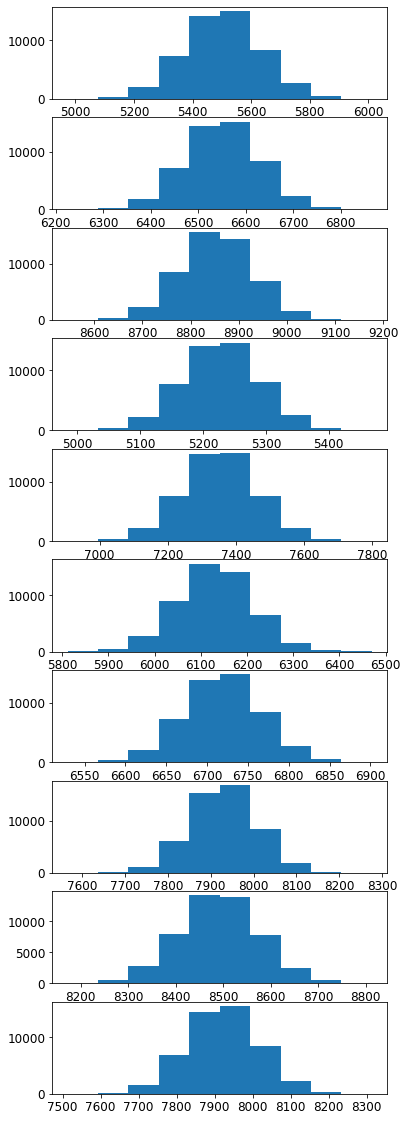

In [12]:
fig = plt.figure(figsize=[6,20])
for i in range(10):
    ax = fig.add_subplot(10,1,i+1)
    ax.hist(theta[i,:],10)
# fig.show()

## Sample of bootstrap

mu
Hierarchical model:	 mu=7004.29, 15%=6812.81,  85%=7194.45
bootstrapping:		 mu=7005.45, 15%=6821.12,  85%=7189.54


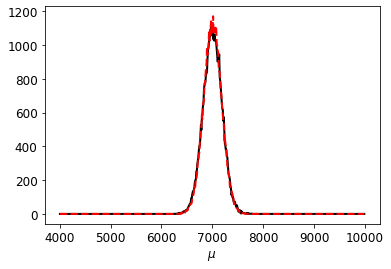

In [20]:
#bootstrapping for mean redshift
def bootstrap(func, x, N, alpha=0.15):
    '''
    Run a boots
    
    Parameters:
    func: function using x as arguement
    x: data
    N: number of repeat
    alpha: percentile
    '''
    nx = len(x)
    xb = np.random.choice(x, (nx,N), replace=True)
    #print np.shape(xb)
    yb = func(xb,axis=0)
    lower = np.percentile(yb, alpha*100)
    upper = np.percentile(yb, (1.-alpha)*100)
    med = np.percentile(yb, 50)
    return yb, lower, upper, med

mu_b,lower_b,upper_b, med_b = bootstrap(np.mean, cz, N)

#draw posterior density of mu p(mu|tau,y)
fig = plt.figure()
ax = fig.add_subplot(111)
mugrid = np.arange(4000.,10000,10.)
mucenter = (mugrid[:-1]+mugrid[1:])/2.0
hmd,xedge = np.histogram(mu_d, bins=mugrid)
hmb,xedge = np.histogram(mu_b, bins=mugrid)
ax.plot(mucenter,hmd,'k',linewidth=2)
ax.plot(mucenter,hmb,'r--',linewidth=2)
ax.set_xlabel(r'$\mu$',fontsize=12)
# fig.show()

alpha=0.15
lower_d = np.percentile(mu_d, alpha*100)
upper_d = np.percentile(mu_d, (1.-alpha)*100)
med_d = np.percentile(mu_d, 50)
print( 'mu')
print( 'Hierarchical model:\t mu=%(m).2f, 15%%=%(l).2f,  85%%=%(u).2f' %\
    {'m':med_d, 'l':lower_d, 'u':upper_d})
print( 'bootstrapping:\t\t mu=%(m).2f, 15%%=%(l).2f,  85%%=%(u).2f' %\
    {'m':med_b, 'l':lower_b, 'u':upper_b})
    


tau:
Hierarchical model:	 mu=1348.49, 15%=1221.99,  85%=1497.88
bootstrapping:		 mu=1301.83, 15%=1202.25,  85%=1400.31


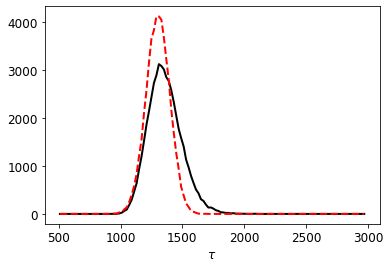

In [21]:
#std. bootstrapping
std_b,lower_b,upper_b, med_b = bootstrap(np.std, cz, N)

#draw posterior density of tau p(tau|y)
fig = plt.figure()
ax = fig.add_subplot(111)
taugrid = np.arange(500,3000,20)
taucenter = (taugrid[:-1]+taugrid[1:])/2.0
htau,xedge = np.histogram(tau_d, bins=taugrid)
hstd_b,xedge = np.histogram(std_b, bins=taugrid)
ax.plot(taucenter,htau,'k',linewidth=2)
ax.plot(taucenter,hstd_b,'r--',linewidth=2)
ax.set_xlabel(r'$\tau$',fontsize=12)
# fig.show()

alpha=0.15
lower_d = np.percentile(tau_d, alpha*100)
upper_d = np.percentile(tau_d, (1.-alpha)*100)
med_d = np.percentile(tau_d, 50)
print( 'tau:')
print( 'Hierarchical model:\t mu=%(m).2f, 15%%=%(l).2f,  85%%=%(u).2f' %\
    {'m':med_d, 'l':lower_d, 'u':upper_d})
print( 'bootstrapping:\t\t mu=%(m).2f, 15%%=%(l).2f,  85%%=%(u).2f' %\
    {'m':med_b, 'l':lower_b, 'u':upper_b})